# Binary classification

In [1]:
import torch 
import torch.nn as nn
import torchmetrics
from torch.utils.data import Dataset
import pandas as pd
import wandb

## Config

In [2]:
import torch.nn as nn 


BATCH_SIZE = 32
LR = 0.001
CLASSES = 2

MAX_EPOCHS = 50
POS_WEIGHT = 2
LOSS_FUNCTION = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([POS_WEIGHT]))
TRAIN_VAL_TEST_SPLIT = [0.9, 0.05, 0.05]
DROPOUT_COEF = 0.35


SAVE_BEST_MODEL = True
IS_MULTICLASS = True if CLASSES > 2 else False
NUM_OF_WORKERS = 0

REDUCE_LR_PATIENCE = 10
EARLY_STOPPING_PATIENCE = 10


## WANDB Init

In [ ]:


wandb.init(project="zneus-project-1-binary", name=f"Basic model with BatchNorm POS_WEIGHT={POS_WEIGHT} and layer and dropouts")

# Config hyperparameters
config = wandb.config
config.pos_weight = POS_WEIGHT
config.batch_size = BATCH_SIZE
config.learning_rate = LR
config.max_epochs = MAX_EPOCHS
config.dropout_coef = DROPOUT_COEF
config.desc = "MLP: (512, BatchNorm,ReLU,Dropout) (256,BatchNorm, ReLU,Dropout) (128,BatchNorm, ReLU, Dropout) (1)"
config.loss_function = "BinaryCrossentropy with logits"
config.reduce_lr_patience = REDUCE_LR_PATIENCE
config.early_stopping_patience = EARLY_STOPPING_PATIENCE


'\n\nwandb.init(project="zneus-project-1-binary", name=f"Basic model with BatchNorm POS_WEIGHT={POS_WEIGHT} and layer and dropouts")\n\n# Config hyperparameters\nconfig = wandb.config\nconfig.pos_weight = POS_WEIGHT\nconfig.batch_size = BATCH_SIZE\nconfig.learning_rate = LR\nconfig.max_epochs = MAX_EPOCHS\nconfig.dropout_coef = DROPOUT_COEF\nconfig.desc = "MLP: (512, BatchNorm,ReLU,Dropout) (256,BatchNorm, ReLU,Dropout) (128,BatchNorm, ReLU, Dropout) (1)"\nconfig.loss_function = "BinaryCrossentropy with logits"\nconfig.reduce_lr_patience = REDUCE_LR_PATIENCE\nconfig.early_stopping_patience = EARLY_STOPPING_PATIENCE\n'

## Define Dataset

In [4]:

class SteelPlateDataset(Dataset):

    def __init__(self, dataset_path):
        super().__init__()
        self.path = dataset_path
        self.df = pd.read_csv(self.path)

        self.features = self.df.drop(["Class", *("Pastry Z_Scratch K_Scratch Stains Dirtiness Bumps".split(" "))] ,axis= 1).values.tolist() # V28 V29 V30 V31 V32 V33
        self.labels = self.df["Class"].to_list()

    def __getitem__(self, index):

        return torch.tensor(self.features[index]), torch.tensor(self.labels[index])
    def __len__(self):
        return len(self.labels)
        



## Create datasets

In [5]:
torch.manual_seed(42)


dataset = SteelPlateDataset("data/norm_multiclass_data.csv")

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, TRAIN_VAL_TEST_SPLIT)


## Define device

In [6]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"

## Define EarlyStopping class

In [7]:
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


## Define model

In [ ]:

from torchmetrics.classification import Accuracy, BinaryPrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_size, lr=0.001, loss_fn=nn.BCELoss(), num_classes=2, reduce_lr_patience=10, early_stopping_patience=10):
        super().__init__()
        self.accuracy = Accuracy(task="binary")
        # Use BinaryPrecision for positive class
        self.precision_pos = BinaryPrecision()  # Precision for positive class (label 1)
        self.precision_neg = BinaryPrecision()  # Precision for negative class (label 0)
        self.loss_fn = loss_fn

        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_COEF),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_COEF),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(DROPOUT_COEF),


            nn.Linear(128, 1)
        )
        self.to(device_name)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.01)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=reduce_lr_patience)

    def forward(self, x):
        return self.model(x)

    def evaluate(self, dataloader):
        self.eval()
        eval_loss = 0
        self.precision_pos.reset()
        self.precision_neg.reset()
        self.accuracy.reset()

        with torch.no_grad():
            for batch in dataloader:
                x = batch[0].to(device_name)
                y = batch[1].to(device_name)
                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()

                loss = self.loss_fn(output, y)
                eval_loss += loss.item()

                # Update metrics
                self.accuracy(output, y)
                self.precision_pos(output, y)  # Positive class precision
                self.precision_neg(1 - output, 1 - y)  # Negative class precision

        self.train()
        return (eval_loss / len(dataloader), self.accuracy.compute(), 
                torch.tensor([self.precision_neg.compute(), self.precision_pos.compute()]))

    def fit(self, train_dataloader, val_dataloader, epochs=10):
        self.train()
        best_val_loss = 9999

        for i in range(epochs):
            self.accuracy.reset()
            self.precision_pos.reset()
            self.precision_neg.reset()
            epoch_loss = 0

            for batch in train_dataloader:
                x = batch[0].to(device_name)
                y = batch[1].to(device_name)
                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()

                loss = self.loss_fn(output, y)
                epoch_loss += loss.item()

                # Update metrics
                self.accuracy(output, y)
                self.precision_pos(output, y)  # Positive class
                self.precision_neg(1 - output, 1 - y)  # Negative class

                self.zero_grad()
                loss.backward()
                self.optimizer.step()

            epoch_loss /= len(train_dataloader)
            epoch_acc = self.accuracy.compute()
            epoch_precision = torch.tensor([self.precision_neg.compute(), self.precision_pos.compute()])

            val_loss, val_acc, val_precision = self.evaluate(val_dataloader)

            if best_val_loss > val_loss:
                best_val_loss = val_loss
                torch.save(self.state_dict(), "best-model-binary.pth")

            self.scheduler.step(val_loss)
           
            wandb.log({
                "epoch": i,
                "Train Loss": epoch_loss,
                "Train Acc": epoch_acc,
                "Train Positive Precision": epoch_precision[1].item(),
                "Train Negative Precision": epoch_precision[0].item(),
                "Val Loss": val_loss,
                "Val Acc": val_acc,
                "Val Positive Precision": val_precision[1].item(),
                "Val Negative Precision": val_precision[0].item(),
                "LR": self.optimizer.param_groups[0]['lr']
            })
            
            
            print(f"Epoch {i+1} Loss:{epoch_loss:.4f} Accuracy:{epoch_acc:.4f} "
                  f"Positive Precision:{epoch_precision[1].item():.4f} Negative Precision:{epoch_precision[0].item():.4f} "
                  f"Val Loss:{val_loss:.4f} Val Accuracy:{val_acc:.4f} "
                  f"Val Positive Precision:{val_precision[1].item():.4f} Val Negative Precision:{val_precision[0].item():.4f} "
                  f"LR = {self.optimizer.param_groups[0]['lr']}")
            self.early_stopping(val_loss)
            if self.early_stopping.early_stop:
                print("Early stopping")
                break
        wandb.finish()

## Create dataloaders

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Default shuffling for training
    num_workers=NUM_OF_WORKERS
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for validation
    num_workers=NUM_OF_WORKERS
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for test
    num_workers=NUM_OF_WORKERS
)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1452
Validation dataset size: 81
Test dataset size: 80


## Create model

In [10]:
model = MyModel(
    input_size=len(dataset.features[0]),
    num_classes=CLASSES, 
    loss_fn=LOSS_FUNCTION, 
    lr=LR, 
    reduce_lr_patience=REDUCE_LR_PATIENCE, 
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

## Train model

In [11]:
model.fit(train_dataloader, val_dataloader, epochs=MAX_EPOCHS)

Epoch 1 Loss:0.9208 Accuracy:0.6398 Positive Precision:0.5017 Negative Precision:0.7343 Val Loss:0.8914 Val Accuracy:0.7407 Val Positive Precision:0.7692 Val Negative Precision:0.7273 LR = 0.001
Epoch 2 Loss:0.8741 Accuracy:0.7273 Positive Precision:0.6443 Negative Precision:0.7642 Val Loss:0.8612 Val Accuracy:0.7407 Val Positive Precision:0.7692 Val Negative Precision:0.7273 LR = 0.001
Epoch 3 Loss:0.8533 Accuracy:0.7472 Positive Precision:0.6688 Negative Precision:0.7846 Val Loss:0.8567 Val Accuracy:0.7407 Val Positive Precision:0.7692 Val Negative Precision:0.7273 LR = 0.001
Epoch 4 Loss:0.8418 Accuracy:0.7596 Positive Precision:0.6789 Negative Precision:0.8010 Val Loss:0.8359 Val Accuracy:0.7778 Val Positive Precision:0.7576 Val Negative Precision:0.7917 LR = 0.001
Epoch 5 Loss:0.8400 Accuracy:0.7652 Positive Precision:0.6885 Negative Precision:0.8039 Val Loss:0.8552 Val Accuracy:0.7531 Val Positive Precision:0.7778 Val Negative Precision:0.7407 LR = 0.001
Epoch 6 Loss:0.8363 Accur

In [12]:
val_loss, val_acc, val_precision = model.evaluate(val_dataloader)
print(f"Val Loss:{val_loss} Val Accuracy:{val_acc.item()} Val Negative Precision:{val_precision[0].item()} Val Positive Precision:{val_precision[1].item()}")

Val Loss:0.8322668870290121 Val Accuracy:0.7777777910232544 Val Negative Precision:0.7916666865348816 Val Positive Precision:0.7575757503509521


## Confusion Matrix on validation set 

[[38  8]
 [10 25]]


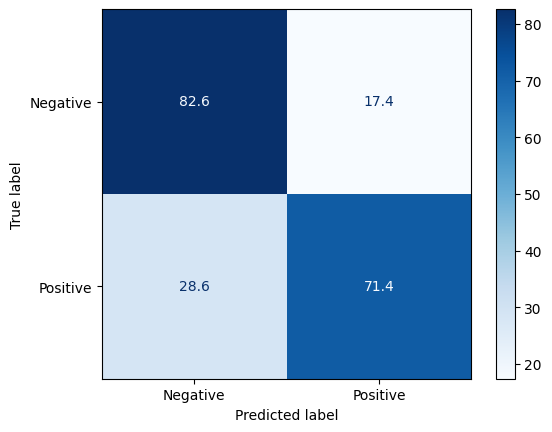

In [13]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=True,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(val_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
predictions = (torch.sigmoid(predictions) > 0.5).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()


cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print(cm)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Negative","Positive"])

disp.plot(cmap='Blues', values_format='.1f')



   



## Load the best model by loss

In [14]:
model.load_state_dict(torch.load("best-model-binary.pth", map_location=device_name))

<All keys matched successfully>

[[38  8]
 [ 7 28]]


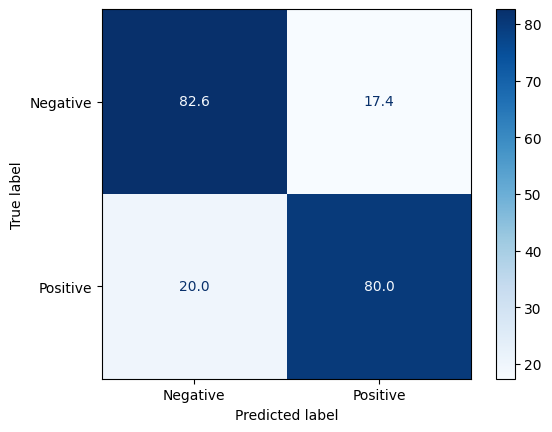

In [15]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=True,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(val_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
predictions = (torch.sigmoid(predictions) > 0.5).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()


cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print(cm)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Negative","Positive"])

disp.plot(cmap='Blues', values_format='.1f')



   



## Test on the test set (only for final evaluation)

### Test set class distribution

In [16]:
from collections import Counter

labels = [label.item() for _, label in test_dataset]
class_counts = Counter(labels)

print("\nClass Distribution:")
print("-" * 30)
class_names = ["No", "Yes"]
for cls, count in sorted(class_counts.items()):
    print(f"Class {class_names[int(cls)]} | Count: {count}")
print("-" * 30)



Class Distribution:
------------------------------
Class No | Count: 52
Class Yes | Count: 28
------------------------------


In [17]:
test_loss, test_acc, test_precision = model.evaluate(test_dataloader)
print(f"Test Loss:{test_loss} Test Accuracy:{test_acc.item()} Test Negative Precision:{test_precision[0].item()} Test Positive Precision:{test_precision[1].item()}")

Test Loss:0.8151968320210775 Test Accuracy:0.800000011920929 Test Negative Precision:0.8103448152542114 Test Positive Precision:0.7727272510528564


### Confusion Matrix

[[47  5]
 [11 17]]


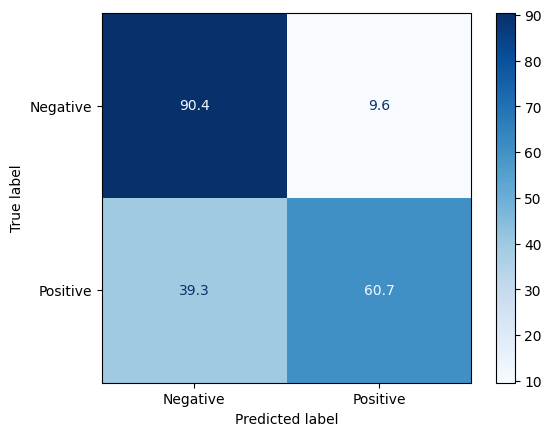

In [18]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(test_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
predictions = (torch.sigmoid(predictions) > 0.5).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()


cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print(cm)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Negative","Positive"])

disp.plot(cmap='Blues', values_format='.1f')



   

